In [1]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from traceback import format_exc
from sklearn import metrics

import torch
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
label_column_names = []
label_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# CSV DataSet & DataLoader Classes
class CSVDataset(torch.utils.data.Dataset):
    """
    Read and make CSV file as a Torch dataset for training and testing dataloaders
    """

    def __init__(self, data: np.ndarray, targets: np.ndarray,
                 transforms=None, device: str = None, classify: bool = False):
        """
        Initialize csv torch dataset class

        @param data: Scaled data array (dtype: np.ndarray)
        @param targets: Scaled target array (dtype: np.ndarray)
        @param transforms: Any additional transforms (default: None)
        @param device: Device to load data onto ('cpu' or 'cuda')
        @param classify: Whether the targets are for classification (dtype: bool, default: False)
        """

        target_dtype = torch.long if classify else torch.float32
        self.data = torch.tensor(data, dtype=torch.float32, device=device).unsqueeze(-1)
        self.targets = torch.tensor(targets, dtype=target_dtype, device=device)
        self.transforms = transforms
        self.classify = classify

    def __getitem__(self, ind):
        """
        Retrieve target and data by index

        @param ind: Index
        """

        data = self.data[ind]
        target = self.targets[ind]

        if target.dim() > 1:
            target = target.view(target.size(0), -1)

        if self.transforms:
            data = self.transforms(data)
        return data, target

    def __len__(self):
        """
        Retrieves the total length of the dataset
        """

        return len(self.data)


def get_csv_dataloader(csv_file: str,
                       target_col: str,
                       batch_size: int = 32,
                       train_split_size: float = 0.8,
                       transforms=None,
                       exclude_cols: list = [],
                       data_scaler=MinMaxScaler(),
                       target_scalar=MinMaxScaler(),
                       norm_target: bool = True,
                       norm_data: bool = True,
                       classify: bool = False,
                       seed: int = 123,
                       device: str = 'cpu'
                       ):
    """
    Load CSV file as a Dataset and retrieve Train & Test DataLoaders from CSV data

    @param csv_file: Filepath to csv file (dtype: str)
    @param target_col: Target Column (dtype: str)
    @param batch_size: Total batch size (dtype: int, default: 32)
    @param train_split_size: Ratio to split Train data and Remainder is Test Dataset (dtype: float, default: 0.8)
    @param transforms: Functional transformations to apply to data before batching (default: None)
    @param exclude_cols: List of column names to exclude from data loader (dtype: list, default: [])
    """

    # Assert that csv_file is a file and exists
    assert os.path.exists(csv_file) and os.path.isfile(csv_file)

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    # Read CSV into pandas dataframe
    dataset = pd.read_csv(csv_file)

    # Drop excluded columns from dataset
    if exclude_cols:
        dataset = dataset.drop(columns=exclude_cols, errors='ignore')

    # Preprocess dataset for string categories
    dataset = pre_process_categories(dataset, fit=True)
    # Separate features and target
    targets = dataset[target_col].values
    data = dataset.drop(columns=[target_col]).values
    # Replace nans with zeros
    data[np.isnan(data)] = 0
    targets[np.isnan(targets)] = 0
    # Apply norm_scaler to the data
    if norm_data:
        data = data_scaler.fit_transform(data)

    if norm_target:
        targets = target_scalar.fit_transform(targets.reshape(-1, 1)).flatten()

    # Create dataset instance
    full_dataset = CSVDataset(data, targets, transforms=transforms, device=device, classify=classify)
    # Calculate train and test sizes
    train_size = int(train_split_size * len(full_dataset))
    test_size = len(full_dataset) - train_size
    # Split the dataset
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size],
                                                                generator=torch.Generator().manual_seed(seed))
    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Return train and test dataloaders
    return train_loader, test_loader

def get_csv_data(csv_file: str,
                 target_col: str,
                 train_split_size: float = 0.8,
                 exclude_cols: list = [],
                 data_scaler=MinMaxScaler(),
                 target_scalar=MinMaxScaler(),
                 norm_target: bool = True,
                 seed: int = 123
                 ):
    """
    Load CSV file as a Dataset and retrieve Train & Test DataLoaders from CSV data

    @param csv_file: Filepath to csv file (dtype: str)
    @param target_col: Target Column (dtype: str)
    @param train_split_size: Ratio to split Train data and Remainder is Test Dataset (dtype: float, default: 0.8)
    @param exclude_cols: List of column names to exclude from data loader (dtype: list, default: [])
    """

    # Assert that csv_file is a file and exists
    assert os.path.exists(csv_file) and os.path.isfile(csv_file)

    # assert seed
    np.random.seed(seed)

    # Read CSV into pandas dataframe
    dataset = pd.read_csv(csv_file)

    # Drop excluded columns from dataset
    if exclude_cols:
        dataset = dataset.drop(columns=exclude_cols, errors='ignore')

    # Preprocess dataset for string categories
    dataset = pre_process_categories(dataset, fit=True)
    # Separate features and target
    targets = dataset[target_col].values
    data = dataset.drop(columns=[target_col]).values
    # Replace nans with zeros
    data[np.isnan(data)] = 0
    targets[np.isnan(targets)] = 0
    # Apply norm_scaler to the data
    data = data_scaler.fit_transform(data)

    if norm_target:
        targets = target_scalar.fit_transform(targets.reshape(-1, 1)).flatten()

    # split data and targets into train/test datasets
    x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=1 - train_split_size,
                                                        random_state=seed)

    # Return train and test datasets
    return x_train, x_test, y_train, y_test, targets


def pre_process_categories(df: pd.DataFrame, fit=True):
    global label_column_names, label_encoder
    df_copy = df.copy()

    if fit:
        label_column_names = [col for col in df_copy.columns if all(isinstance(val, str) for val in df[col].dropna())]
        df_copy[label_column_names] = label_encoder.fit_transform(df_copy[label_column_names].astype(str)).astype(int)
    else:
        df_copy[label_column_names] = label_encoder.transform(df_copy[label_column_names].astype(str)).astype(int)

    df_copy = df_copy.replace([np.inf, -np.inf], np.nan)
    return df_copy

def display_evaluations(eval_stats, save_file_path):
    directory = os.path.dirname(save_file_path)

    # Check if the directory exists....
    if directory and not os.path.exists(directory):
        # If not, create directory
        os.makedirs(directory, exist_ok=True)

    try:
        titles = eval_stats.keys()
        colors = ['blue', 'red', 'green', 'purple']

        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        axs = axs.flatten()

        for i, (key, color) in enumerate(zip(titles, colors)):
            # Prepare x and y data
            x = list(range(1, len(eval_stats[key]) + 1))
            y = eval_stats[key]

            # Plot data
            axs[i].plot(x, y, label=key, color=color)
            axs[i].set_title(key)
            axs[i].set_xlabel('Epochs')
            axs[i].set_ylabel(key)
            axs[i].legend()

        # Save and Show plot
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(save_file_path)
        plt.show()
        plt.close(fig)

    except Exception as e:
        # Log error traceback and message
        for err_line in format_exc().splitlines():
            log(err_line)

        log('---------------------------------------------------------------')
        log(f"The Forward Network Algorithm - Last Layer Evaluation Metrics Critical Error ({e})")


def display_predictions(y_true, y_pred, save_file_path):
    directory = os.path.dirname(save_file_path)

    # Check if the directory exists....
    if directory and not os.path.exists(directory):
        # If not, create directory
        os.makedirs(directory, exist_ok=True)

    try:
        # Create a figure
        plt.figure(figsize=(10, 6))

        # Plot actual vs predicted values
        plt.plot(y_true, label='Actual')
        plt.plot(y_pred, label='Predicted', alpha=0.8)

        # Set labels and legend
        plt.xlabel('Number of Samples')
        plt.ylabel('Target Value')
        plt.legend()

        # Save and show figure
        plt.savefig(save_file_path)
        plt.show()
        plt.close()
    except Exception as e:
        # Log error traceback and message
        for err_line in format_exc().splitlines():
            log(err_line)

        log('---------------------------------------------------------------')
        log(f"Display Predictions - Critical Error ({e})")

def log(message: str):
    """
    Prints message with timestamp

    @param message: Message to print (dtype: str)
    @return: None
    """

    # Format print with datetime
    message = "{} - {}".format(datetime.datetime.now(), message)
    # print message
    print(message)

In [3]:
# 3-Layer Neural Network
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.network = torch.nn.Sequential(torch.nn.Linear(23, 1450),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(1450, 1)
                                          )

    def forward(self, x):
        return self.network(x)

experiment_num = 'neural_network'

try:
    # HyperParameters
    EPOCHS = 200
    LR = 0.0008
    FN_BATCH_SIZE = 59
    best_model_save_fp = './nn_best_model.pth'

    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set torch device for cuda if cuda is applicable
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Initialize the network
    nn_mod = NN().to(device)
    # Loss and Optimizer
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(nn_mod.parameters(), lr=LR)
    # Get data loaders and data profile
    train_loader, test_loader = get_csv_dataloader('./complete_dataset.csv',
                                                   'Total Disasters',
                                                   exclude_cols=['Drought', 'Extreme temperature', 'Flood',
                                                                 'Landslide', 'Storm', 'Wildfire'],
                                                   batch_size=FN_BATCH_SIZE,
                                                   seed=seed,
                                                   device=device)
    # Variables
    y_pred, y_true = [], []
    eval_stats = {'Train Losses': [], 'Predict Losses': [], 'MSE': [], 'MAE': []}
    best_mod = (-1, float('inf'))
    
    # Model Training
    for e in range(EPOCHS):
        # Parameter Setting
        train_avg_loss, test_avg_loss = 0, 0
        y_pred, y_true = [], []
        # Set model to train mode
        nn_mod.train()
    
        # Iterate train dataloader
        for x, y in train_loader:
            # find y_hat through traditional neural network
            y_hat = nn_mod(x.squeeze(-1))
            # Zero out gradients
            optimizer.zero_grad()
            # Calculate loss using MSE, y_hat, and y
            loss = loss_func(y_hat.squeeze(), y.squeeze())
            # Perform backward propagation
            loss.backward()
            # Update weights
            optimizer.step()
            # Calculate training loss
            train_avg_loss = (train_avg_loss + loss.item()) / 2
    
        # Set model to evaluation mode
        nn_mod.eval()
        # Set train losses in evaluation stats
        eval_stats['Train Losses'].append(train_avg_loss)
    
        # Iterate through test dataloader
        for x, y in test_loader:
            # find y_hat prediction through traditional neural network
            y_hat = nn_mod(x.squeeze(-1))
            # Calculate loss using MSE, y_hat, and y
            loss = loss_func(y_hat.squeeze(), y.squeeze())
            # Extend prediction list with new predictions
            y_pred.extend(y_hat.squeeze().cpu().detach().tolist() if y_hat.is_cuda else y_hat.detach().tolist())
            # Extend actuals list with actual values
            y_true.extend(y.squeeze().cpu().detach().tolist() if y.is_cuda else y.squeeze().detach().tolist())
            # Calculate overal loss average
            test_avg_loss = (test_avg_loss + loss.cpu().item() if loss.is_cuda else loss.item()) / 2
    
        # Set test losses in evaluation stats
        eval_stats['Predict Losses'].append(test_avg_loss)
        
        if torch.isinf(torch.tensor(y_pred)).any() or torch.isnan(torch.tensor(y_pred)).any():
            eval_stats['MSE'].append(None)
            eval_stats['MAE'].append(None)
            log(f'Epoch: {e + 1}, Train AVG Loss: {train_avg_loss}, Test AVG Loss: {test_avg_loss}, Accuracy: nan, F1 Score: nan')
        else:
            mse_err = metrics.mean_squared_error(y_true, y_pred)
            mae_err = metrics.mean_absolute_error(y_true, y_pred)
            eval_stats['MSE'].append(mse_err)
            eval_stats['MAE'].append(mae_err)
            log(f'Epoch: {e + 1}, Train AVG Loss: {train_avg_loss}, Test AVG Loss: {test_avg_loss}, MSE: {mse_err}, MAE: {mae_err}')
            
            if best_mod[1] > mse_err:
                best_mod = (e + 1, mse_err)
                torch.save(nn_mod.state_dict(), best_model_save_fp)
    
    if best_mod[1] < float('inf'):
        log(f'Loading Best Model Epoch: {best_mod[0]}, by F1 Score: {best_mod[1]:.4f}')
        nn_mod.load_state_dict(torch.load(best_model_save_fp))

    # Set Parameters
    y_pred, y_true = [], []
    avg_loss = 0

    # Iterate through test dataloader
    for x, y in test_loader:
        # find y_hat prediction through traditional neural network
        y_hat = nn_mod(x.squeeze(-1))
        # Calculate loss using MSE, y_hat, and y
        loss = loss_func(y_hat.squeeze(), y.squeeze())
        # Extend prediction list with new predictions
        y_pred.extend(y_hat.squeeze().cpu().detach().tolist() if y_hat.is_cuda else y_hat.detach().tolist())
        # Extend actuals list with actual values
        y_true.extend(y.squeeze().cpu().detach().tolist() if y.is_cuda else y.squeeze().detach().tolist())
        # Calculate overal loss average
        avg_loss = (avg_loss + loss.cpu().item() if loss.is_cuda else loss.item()) / 2

    # Print total average loss of predictions
    log(f'Final Average Loss: {avg_loss}')
    log(f'Mean Absolute Error: {metrics.mean_absolute_error(y_true, y_pred)}')
    log(f'Mean Squared Error: {metrics.mean_squared_error(y_true, y_pred)}')
except Exception as e:
    eval_stats = {'Train Losses': [], 'Predict Losses': [], 'MSE': [], 'MAE': []}
    y_true, y_pred = [], []
    # Print error traceback in case of an error
    for err_line in format_exc().splitlines():
        log(err_line)

    # Print actual error with line seperater
    log('---------------------------------------------------------------')
    log("NN Experiment - Critical Error ({})".format(e))

2024-12-05 22:08:51.092105 - Epoch: 1, Train AVG Loss: 0.06414074210533727, Test AVG Loss: 0.03120172373019159, MSE: 0.034736601867959675, MAE: 0.12896299141769607
2024-12-05 22:08:51.139155 - Epoch: 2, Train AVG Loss: 0.017437123182617142, Test AVG Loss: 0.013044616440311074, MSE: 0.021047806439615162, MAE: 0.09960324152683218
2024-12-05 22:08:51.173899 - Epoch: 3, Train AVG Loss: 0.014578842600258213, Test AVG Loss: 0.012801386415958405, MSE: 0.019637058973512478, MAE: 0.10001063020899892
2024-12-05 22:08:51.217361 - Epoch: 4, Train AVG Loss: 0.013505777434716038, Test AVG Loss: 0.012546415091492236, MSE: 0.017706583805083814, MAE: 0.09443606184795499
2024-12-05 22:08:51.260944 - Epoch: 5, Train AVG Loss: 0.011509944746421752, Test AVG Loss: 0.011932489578612149, MSE: 0.01735225251353117, MAE: 0.09287578928180867
2024-12-05 22:08:51.302760 - Epoch: 6, Train AVG Loss: 0.006910544454740375, Test AVG Loss: 0.012375193648040295, MSE: 0.016743176076600003, MAE: 0.0876915335137811
2024-12-

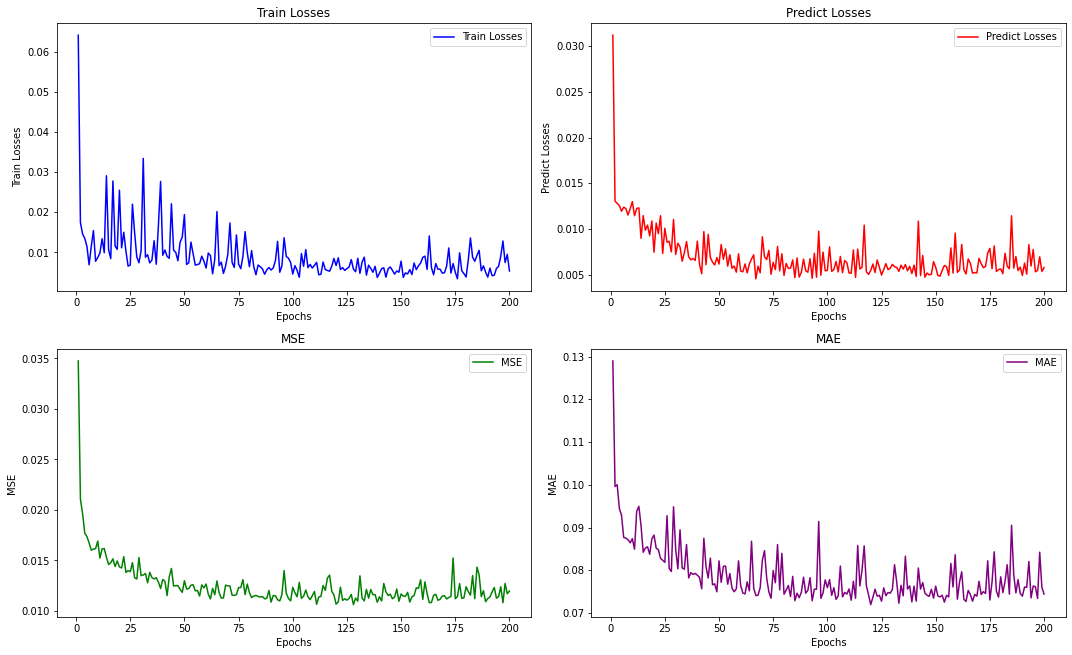

In [5]:
display_evaluations(eval_stats, './climate_change_results/%s_evaluations.png' % experiment_num)

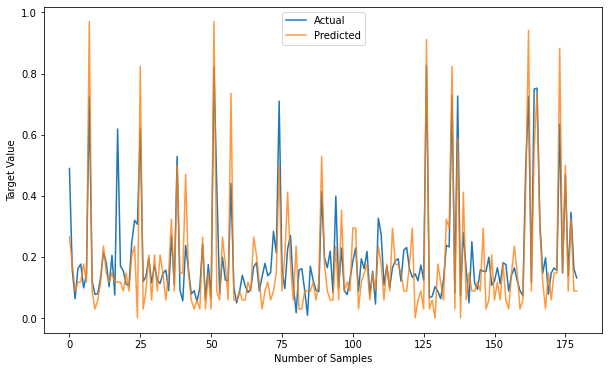

In [6]:
display_predictions(y_pred, y_true, './climate_change_results/%s_predictions_trended.png' % experiment_num)

In [7]:
experiment_num = 'xgb_boost'

# Error handling in case if something goes wrong
try:
    # Set seed for reproducable experiments
    seed = 123

    # Get toy dataloaders for train test
    x_train, x_test, y_train, y_test, y = get_csv_data('./complete_dataset.csv',
                                                       'Total Disasters',
                                                       exclude_cols=['Drought', 'Extreme temperature', 'Flood',
                                                                     'Landslide', 'Storm', 'Wildfire'],
                                                       seed=seed)

    # Tuning Parameter Grid
    param_grid = {
        'xgbregressor__max_depth': [3, 5, 6],
        'xgbregressor__learning_rate': [0.01, 0.1, 0.3],
        'xgbregressor__n_estimators': [50, 100, 200],
        'xgbregressor__subsample': [0.7, 0.8, 1.0],
        'xgbregressor__colsample_bytree': [0.7, 0.8, 1.0]
    }
    # XGB Model
    xgb_mod =  XGBRegressor(objective='reg:squarederror', seed=seed)
    # Data Pipeline
    pipeline = Pipeline([
        ('xgbregressor', xgb_mod)
    ])
    # Create Grid Search training of XGBoost model using cross-fold validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
    # Fit model using training data and targets
    grid_search.fit(x_train, y_train)
    # Print best parameters and Best Train Evaluation
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    # Make predictions on test dataset
    best_mod = grid_search.best_estimator_
    y_pred = best_mod.predict(x_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    # Print Test accuracy and Classification Report
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
except Exception as e:
    # Print error traceback in case of an error
    for err_line in format_exc().splitlines():
        log(err_line)

    # Print actual error with line seperater
    log('---------------------------------------------------------------')
    log("XG Boost Fitting - Critical Error ({})".format(e))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 6, 'xgbregressor__n_estimators': 50, 'xgbregressor__subsample': 0.8}
Best Score: -0.009130338776909115
Mean Absolute Error: 0.07006326126652994
Mean Squared Error: 0.011952577964860496


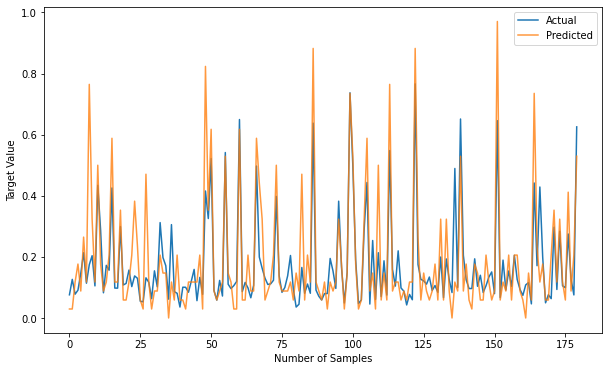

In [8]:
display_predictions(y_pred, y_test, './climate_change_results/%s_predictions_trended.png' % experiment_num)